Here is the library of functions:

In [2]:
def logistic(x):
    '''
    '''
    return 1/(1+np.exp(-x))

def U_logistic(theta, Y, X, phi):
    '''
    '''
    return - (Y.T @ X @ theta - np.sum(np.log(1+np.exp(X @ theta))) - 0.5 * phi * np.sum(theta**2))

def gradU_logistic(theta, Y, X, phi):
    '''
    '''
    n = X.shape[0]
    
    Y_pred = logistic(X @ theta)
    epsilon = (Y[:,np.newaxis] - Y_pred[:,np.newaxis])
    grad = X.T @ epsilon - phi * theta[:, np.newaxis]

    return -grad/n


def hmc(Y, X, U, gradU, M, eps, m, theta0, phi):
    '''
    '''
    theta = theta0.copy()
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Intial energy
    H0 = U(theta0, Y, X, phi) + 0.5 * np.asscalar(r.T @ Minv @ r)
    
    # Hamiltonian dynamics
    r -= (eps/2)*gradU(theta, Y, X, phi)
    for i in range(m):
        theta += (eps*Minv@r).ravel()
        r -= eps*gradU(theta, Y, X, phi)
    r -= (eps/2)*gradU(theta, Y, X, phi)
    
    # Final energy
    H1 = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    # MH step
    u = np.random.uniform()
    rho = np.exp(H0 - H1) # Acceptance probability
    
    if u < np.min((1, rho)):
        # accept
        accept = True
        H = H1
    else:
        # reject
        theta = theta0
        accept = False
        H = H0

    return theta, accept, rho, H


def run_hmc(Y, X, U, gradU, M, eps, m, theta, phi, nsample):

    n, p = X.shape
    
    # Allocate space
    samples = np.zeros((nsample, p))
    accept = np.zeros(nsample)
    rho = np.zeros(nsample)
    H = np.zeros(nsample)
    
    # Run hmc
    for i in range(nsample):
        theta, accept[i], rho[i], H[i] = hmc(Y, X, U, gradU, M, eps, m, theta, phi)
        samples[i] = theta
        
    return samples, accept, rho, H  

def stogradU(theta, Y, X, nbatch, phi):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    n, p = X.shape
    
    # Sample minibatch
    batch_id = np.random.choice(np.arange(n),nbatch,replace=False)
    
    Y_pred = logistic(X[batch_id,:] @ theta[:,np.newaxis])
    epsilon = (Y[batch_id,np.newaxis] - Y_pred)
    grad = n/nbatch * X[batch_id,:].T @ epsilon - phi * theta[:, np.newaxis]

    #return -grad/n
    return -grad

def sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi):
    
    n, p = X.shape
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Hamiltonian dynamics
    for i in range(m):        
        theta += (eps*Minv@r).ravel()
        r -= eps*stogradU(theta, Y, X, nbatch,phi) - eps*C @ Minv @ r \
            + np.random.multivariate_normal(np.zeros(p),D)[:,np.newaxis] 
    
    # Record the energy
    H = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    return theta, H

def run_sghmc(Y, X, U, gradU, M, eps, m, theta, C, V, phi, nsample):
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    B = 0.5 * V * eps
    D = 2*(C-B)*eps
    
    # Allocate space
    samples = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    # Run sghmc
    for i in range(nsample):
        theta, H[i] = sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi)
        samples[i] = theta
        
    return samples, H
    
    
def gd(Y, X, gradU, eps, m, theta, phi):
    '''
    '''
    samples = np.zeros((nsample, p))
    
    for i in range(m):
        theta -= eps*gradU(theta, Y, X, phi).ravel()
      
    return theta     

Everything after here is the script that runs the simulation:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
n = 500
p = 50

beta = np.random.normal(0, 1, p+1)

Sigma = np.zeros((p, p))
Sigma_diags = np.array([25, 5, 0.2**2])
distribution = np.random.multinomial(p, pvals=[.05, .05, .9], size=1).tolist()
np.fill_diagonal(Sigma, np.repeat(Sigma_diags, distribution[0], axis=0))

X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
X = np.hstack((np.ones((n, 1)), X))
p = np.exp(X @ beta)/np.exp(1 + np.exp(X @ beta))
Y = np.random.binomial(1, p, n)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: overflow encountered in exp


In [5]:
Xs = (X - np.mean(X, axis=0))/np.concatenate((np.ones(1),np.std(X[:,1:], axis=0)))
Xs = Xs[:,1:]
p = Xs.shape[1]

### Regression

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
# Unscaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(X,Y)
beta_true_unscale = mod_logis.coef_.ravel()
beta_true_unscale

array([-5.42225498,  0.01547831, -0.03949911, -0.1511635 , -0.2722309 ,
       -0.09100199, -2.73727813, -1.7971303 , -0.30953104, -0.47377722,
        2.34621016,  1.34549371,  1.08053644,  0.59918691, -1.22332945,
       -1.11624256,  0.79974824,  0.13224981, -0.94933377, -2.47822698,
        2.82811929,  2.98914075,  0.52531728,  1.59555514,  0.83180108,
        1.96121504, -1.76470775, -2.08279779,  2.91242892,  0.15922233,
        0.50850869,  0.32948314,  1.63349315,  3.59269183, -0.62336511,
       -1.55130351, -3.54635759, -2.90125667, -2.16873571, -1.12685293,
       -0.17041313,  3.57752513, -2.31812916, -1.81493218,  0.62764699,
       -0.24301057,  2.11960164,  2.27098222, -0.80023992, -1.3852467 ,
       -2.66291888])

In [8]:
# Scaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(Xs,Y)
beta_true_scale = mod_logis.coef_.ravel()
beta_true_scale

array([ 0.00855147, -0.025786  , -0.02069149, -0.04455224, -0.01710307,
       -0.03880742, -0.01416884, -0.0040508 , -0.01175037,  0.03303311,
        0.01820936,  0.01682318,  0.03664091, -0.02723077, -0.01844663,
        0.01333346,  0.00661277, -0.01083257, -0.03051636,  0.03424942,
        0.05900546, -0.00593439,  0.02155367,  0.01593588,  0.02304753,
       -0.02315236, -0.02852955,  0.05254837,  0.01626833,  0.0196769 ,
       -0.00267713,  0.02679894,  0.05751984, -0.00143971,  0.00208216,
       -0.06163702, -0.03958861, -0.01850227,  0.01028051, -0.00179106,
        0.0490896 , -0.00671829, -0.01863964,  0.01530239,  0.01198803,
        0.04434101,  0.0263503 , -0.02833673, -0.02838012, -0.05013156])

### HMC

In [60]:
# HMC - Scaled
nsample = 1000
m = 20
eps = .0005
theta = np.zeros(p)
#theta = beta_true_scale.copy()
phi = 5
M = np.identity(p)

samples, accept, rho, H = run_hmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, theta, phi, nsample)
hmc_mean = np.mean(samples, axis=0)
np.mean(samples, axis=0) - beta_true_scale

array([-0.02099098, -0.04721184, -0.03529398,  0.02051348, -0.0290821 ,
       -0.08224134,  0.02085766, -0.05769712,  0.03323372, -0.04094694,
       -0.00302513,  0.05109093, -0.02297102,  0.04291896,  0.02527097,
        0.00077552, -0.04304507, -0.07261407, -0.04271719,  0.05307519,
        0.04365332,  0.01414896,  0.04462509,  0.18526521, -0.1068556 ,
        0.00493318,  0.05278889, -0.01890154, -0.00201089, -0.08480773,
       -0.07398315, -0.0240367 , -0.04798827,  0.04342425, -0.05611903,
        0.01519648,  0.04347473,  0.08146309,  0.05582658, -0.00841844,
       -0.04769407,  0.06573916, -0.05120551, -0.10621886, -0.00805833,
       -0.02527308,  0.0523847 , -0.00264888, -0.02421885,  0.00065327])

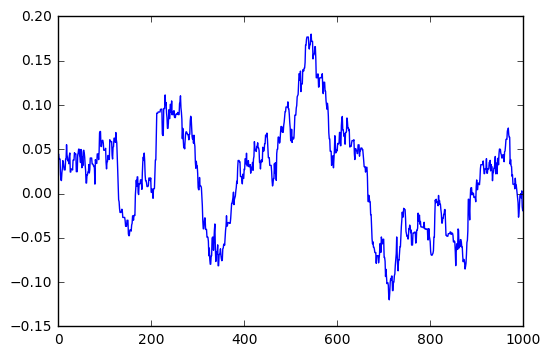

In [61]:
plt.plot((samples - beta_true_scale)[:,3])
plt.show()

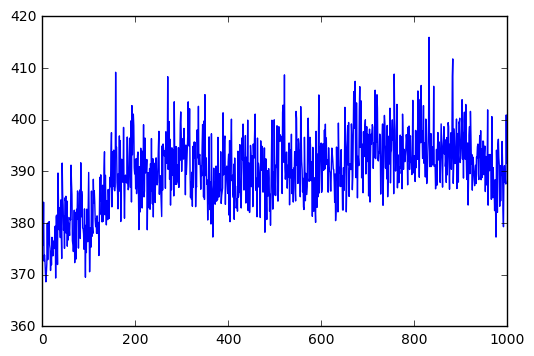

In [62]:
plt.plot(H)
plt.show()

# HMC - Unscaled
nsample = 1000
m = 20
eps = .008
theta = np.zeros(p+1)
#theta = beta_true_unscale.copy()
phi = 5
M = np.identity(p+1)

samples, accept, rho, H = run_hmc(Y, X, U_logistic, gradU_logistic, M, eps, m, theta, phi, nsample)
np.mean(samples, axis=0) - beta_true_unscale

plt.plot((samples - beta_true_unscale)[:,3])
plt.show()

plt.plot(H)
plt.show()

### SGHMC

In [27]:
# HMC - Scaled (no intercept)
nsample = 1000
m = 20
eps = .01
theta = np.zeros(p)
#theta = beta_true_scale.copy()
phi = 5
nbatch = 500
C = 1 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)

samples, H = run_sghmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, theta, C, V, phi, nsample)

print(np.mean(samples, axis=0) - beta_true_scale)

[  2.64294973e-03  -3.13355221e-03  -4.33312027e-03  -6.24025866e-03
  -4.52454425e-04  -9.02758323e-03  -4.59237138e-03  -5.11134470e-04
  -5.15020581e-03  -1.96554849e-04   2.70145507e-03  -1.41981249e-04
   2.69339716e-03   2.26551186e-04   4.80362151e-05   3.97437845e-03
  -1.24553694e-03  -2.61786849e-03  -2.15089541e-03   1.90622170e-03
   7.40155127e-03   1.66367132e-03   4.66144520e-03   4.07216775e-03
  -1.95039986e-03   3.87216685e-03  -6.06619906e-03   6.13150212e-03
   2.49314555e-03   2.39190808e-03  -6.59074346e-04   5.67741024e-04
   3.13137716e-03  -2.42874017e-03  -1.54135970e-03  -8.50535191e-03
  -3.74590098e-03  -3.58592283e-03   3.04081775e-03   2.47125737e-03
   5.35374558e-03  -3.15809756e-03   1.66756420e-03   2.09845233e-03
   2.14738604e-03   7.37012826e-03   4.31575218e-03  -1.82766024e-03
  -2.86196547e-03  -7.29998320e-03]


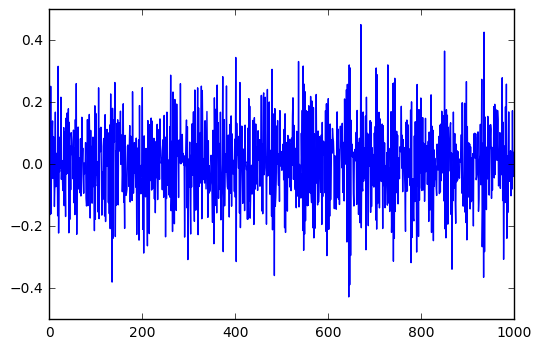

In [28]:
plt.plot((samples - beta_true_scale)[:,0])
plt.show()

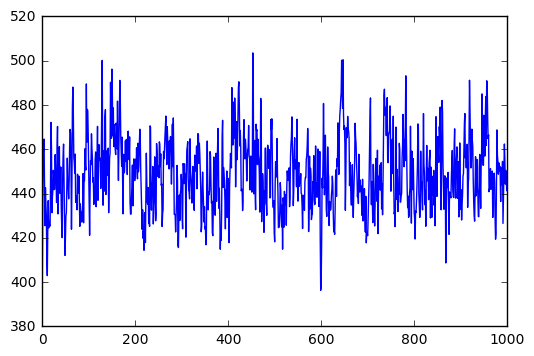

In [29]:
plt.plot(H)
plt.show()

# HMC - Unscaled (no intercept)
nsample = 1000
m = 20
eps = .00001
theta = np.zeros(p+1)
#theta = beta_true_scale.copy()
phi = 5
nbatch = 500
C = 1 * np.identity(p+1)
V = 0 * np.identity(p+1)
M = np.identity(p+1)

samples, H = run_sghmc(Y, X, U_logistic, gradU_logistic, M, eps, m, theta, C, V, phi, nsample)

print(np.mean(samples, axis=0) - beta_true_unscale)

plt.plot((samples - beta_true_unscale)[:,0])
plt.show()

plt.plot(H)
plt.show()

### Gradient Descent

In [ ]:
# Gradient descent - Scaled
np.random.seed(2)
phi = .1

res = gd(Y, Xs, gradU_logistic, .1, 20000, np.zeros(p), phi)

res - beta_true_scale